In [1]:
#!/home/valsesia/tensorflow-python2.7/bin/python
import os
import os.path as osp
import numpy as np
import shutil
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

BASE = os.path.dirname(os.path.abspath(os.path.dirname("file")))
sys.path.append(BASE)

from config import Config
from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, load_all_point_clouds_under_folder
from gan import GAN
from src.general_utils import *
from PIL import Image
from src.tf_utils import reset_tf_graph

import scipy.io as sio
from tqdm import tqdm, trange
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
code = 'gconv_up_aggr'
class_name = 'chair'
render_dir = osp.join(BASE, 'Results', code, class_name, 'renders') + '/'
log_dir = osp.join(BASE, 'log_dir', code, class_name) + '/'
save_dir = osp.join(BASE, 'Results', code, class_name, 'saved_models') + '/'
top_in_dir = 'data/shape_net_core_uniform_samples_2048/'




import easydict
args = easydict.EasyDict({
    "class_name": class_name,
    "start_iter": 1,
    "render_dir": render_dir,
    "log_dir" : log_dir,
    "save_dir" : save_dir
})
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--class_name', default=class_name, help='Shapenet class')
# parser.add_argument('--start_iter', type=int, default=299, help='Start iteration (ex: 10001)')
# parser.add_argument('--render_dir', default=render_dir, help='Renders directory')
# parser.add_argument('--log_dir', default=log_dir, help='Tensorboard log directory')
# parser.add_argument('--save_dir', default=save_dir, help='Trained model directory')
# param = parser.parse_args()

In [4]:
# import config
config = Config()
config.render_dir = args.render_dir
config.log_dir = args.log_dir
config.save_dir = args.save_dir

#class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
class_name = args.class_name
# config.render_dir = param.render_dir
# config.log_dir = param.log_dir
# config.save_dir = param.save_dir
# 
# #class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
# class_name = param.class_name

# import data
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(BASE, config.top_in_dir, syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

# reset_tf_graph()
model = GAN(config)
model.do_variables_init()

6778 pclouds were loaded. They belong in 1 shape-classes.


In [5]:
if args.start_iter==1:
    start_iter = 0
    config.N_iter = config.N_iter+1
    
    # delete old renders
    if os.path.exists(config.render_dir):
#         shutil.rmtree(config.render_dir)

    if not os.path.exists(config.render_dir):
        os.makedirs(config.render_dir)

else:
    start_iter = args.start_iter
    model.restore_model(config.save_dir+'model.ckpt')
    print('Resuming training from iter %d' % start_iter)

print("batch size: %d \t start iter: %d \t iter: %d" %(config.batch_size, start_iter, config.N_iter))

batch size: 35 	 start iter: 0 	 iter: 100001


0


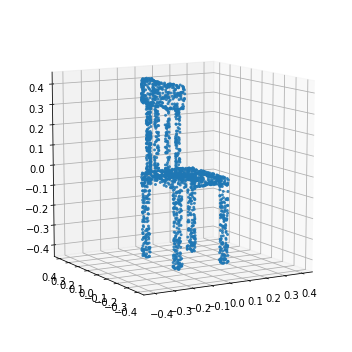

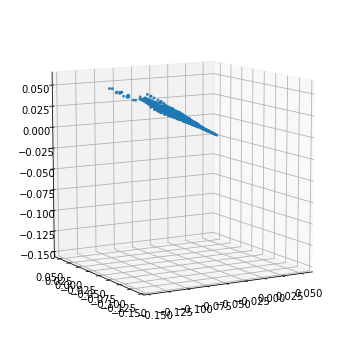

100


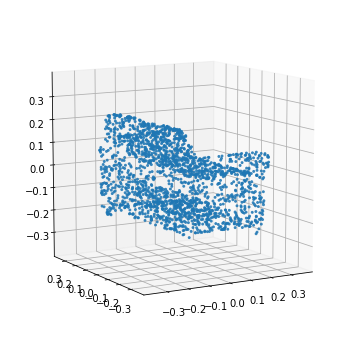

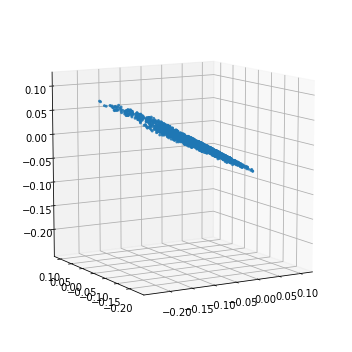

200


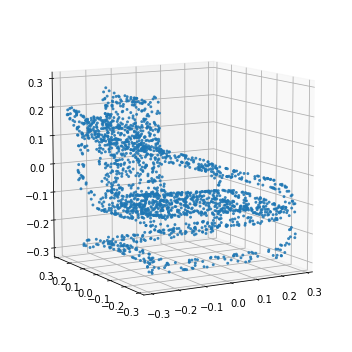

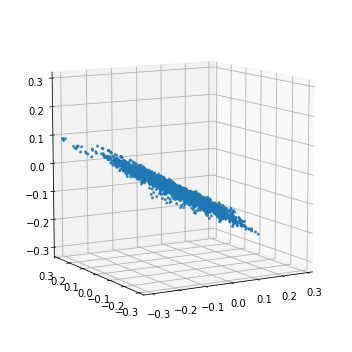

300


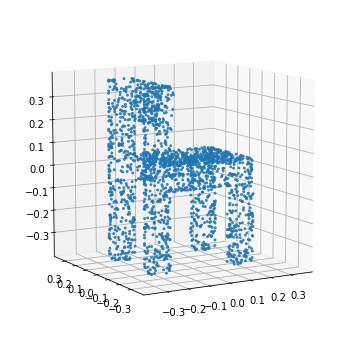

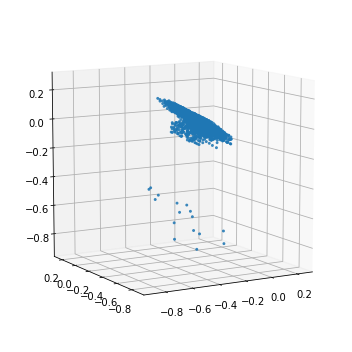

400


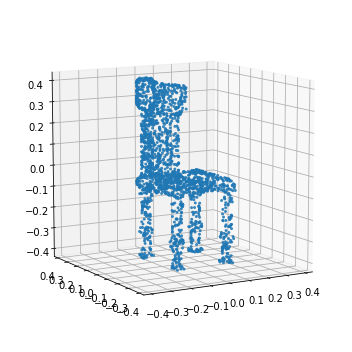

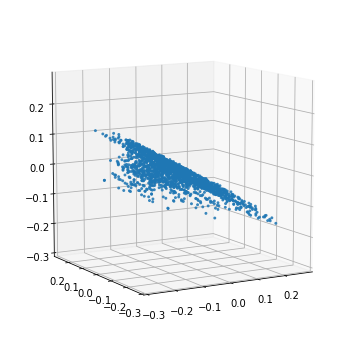

500


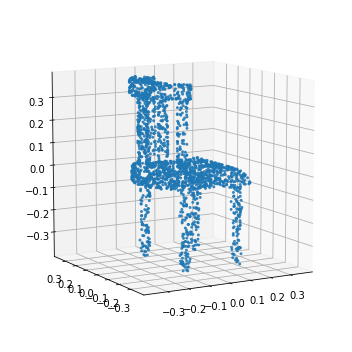

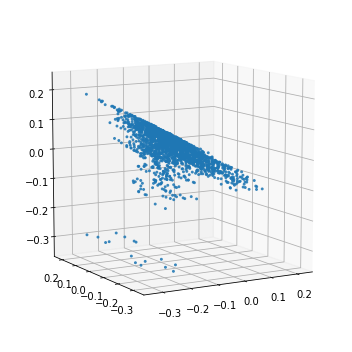

600


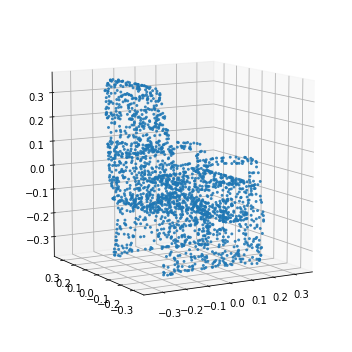

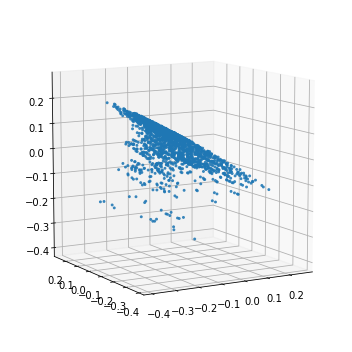

700


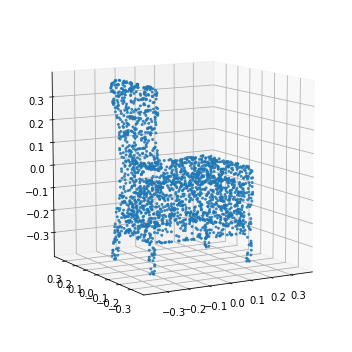

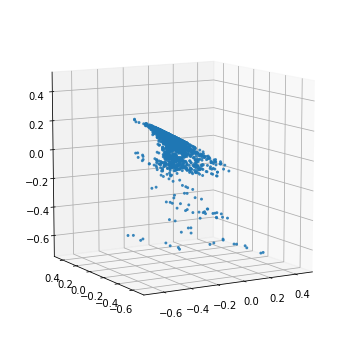

800


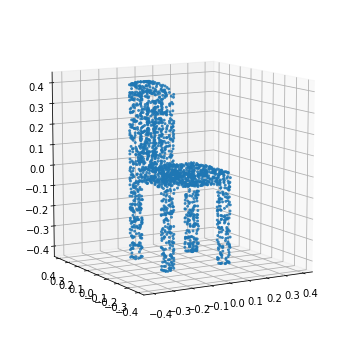

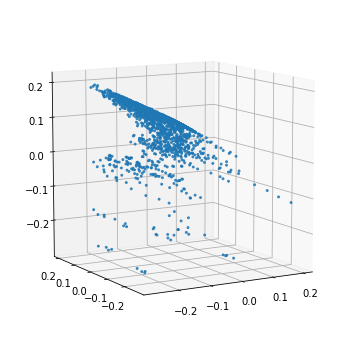

900


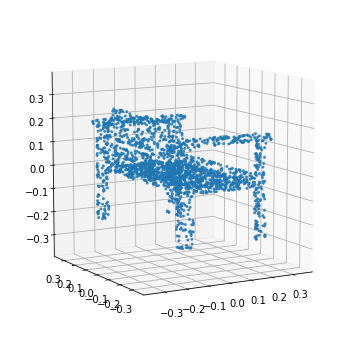

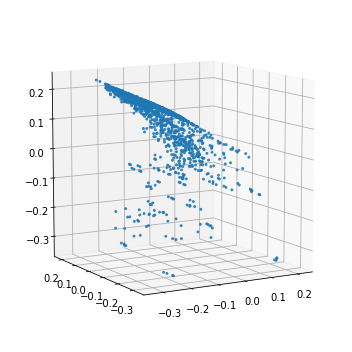

1000


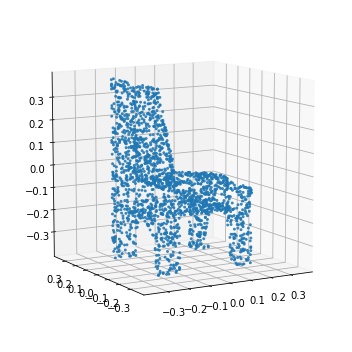

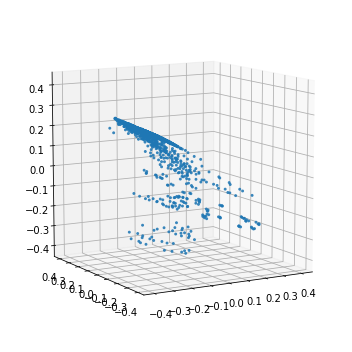

KeyboardInterrupt: 

In [6]:
# training

from tqdm import tqdm_notebook
from tqdm import trange
# for iter_no in tqdm.trange(range(start_iter, config.N_iter)):
for iter_no in tqdm_notebook(range(start_iter, config.N_iter)):

    for dis_iter in range(config.dis_n_iter):
        noise = np.random.normal(size=[config.batch_size, config.z_size], scale=0.2)
        data = all_pc_data.next_batch(config.batch_size)[0]
        model.fit(data, noise, iter_no, dis_iter)

    noise = np.random.normal(size=[config.batch_size, config.z_size], scale=0.2)
    data = all_pc_data.next_batch(config.batch_size)[0]
    pc_gen = model.fit(data, noise, iter_no, config.dis_n_iter)

    if iter_no % 1000 == 0:
        sio.savemat('%srender_%d.mat' % (config.render_dir, iter_no), {'X_hat': pc_gen})
        np.save('%srender_%d' % (config.render_dir, iter_no), pc_gen)
        sio.savemat('%sref_%d.mat' % (config.render_dir, iter_no), {'X': data})
        np.save('%sref_%d' % (config.render_dir, iter_no), data)
        sio.savemat('%snoise_%d.mat' % (config.render_dir, iter_no), {'Z': noise})
        np.save('%snoise_%d' % (config.render_dir, iter_no), noise)

    # save image of point cloud
    if iter_no % config.renders_every_iter == 0:
        pc_gen = np.reshape(pc_gen[0, :], [2048, 3])
        im_array = point_cloud_three_views(pc_gen)
        img = Image.fromarray(np.uint8(im_array * 255.0))
        img.save('%srender_%d.jpg' % (config.render_dir, iter_no))

        data_ref = np.reshape(data[0, :], [2048, 3])
        im_array_ref = point_cloud_three_views(data_ref)
        img_ref = Image.fromarray(np.uint8(im_array_ref * 255.0))
        img_ref.save('%sref_%d.jpg' % (config.render_dir, iter_no))

#         plot_3d_point_cloud(pc_gen[:, 0], pc_gen[:, 1], pc_gen[:, 2], in_u_sphere=False)
#         # 
#         output_filename = '%sdraw_%d.jpg' % (config.render_dir, iter_no)
#         pyplot_draw(pc_gen, output_filename)
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')
        # ax.scatter(pc_gen[:, 0], pc_gen[:, 1], pc_gen[:, 2])
        # ax.set_xlabel('x')
        # ax.set_ylabel('y')
        # ax.set_zlabel('z')
        # ax.view_init(20, 100)
        # plt.show()
        print(iter_no)
        plot_3d_point_cloud(data_ref[:, 0], data_ref[:, 1], data_ref[:, 2], s = 15, in_u_sphere=False)
        plot_3d_point_cloud(pc_gen[:, 0], pc_gen[:, 1], pc_gen[:, 2], s = 15, in_u_sphere=False)


    if iter_no % config.save_every_iter == 0:
        model.save_model(config.save_dir+'model.ckpt')

    if iter_no % 10000 == 0:
        if not os.path.exists(config.save_dir + str(iter_no)):
            os.mkdir(config.save_dir + str(iter_no))
    model.save_model(config.save_dir+str(iter_no)+'/model.ckpt')

    if iter_no % 10:
        with open(config.log_dir+'start_iter', "w") as text_file:
            text_file.write("%d" % iter_no)
    

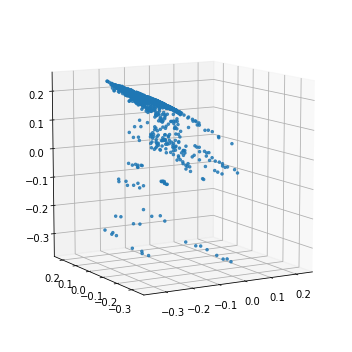

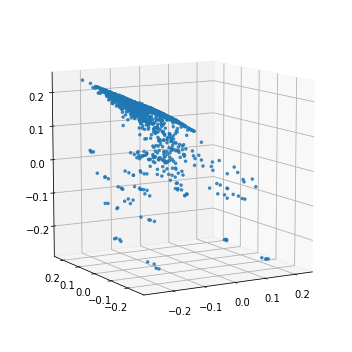

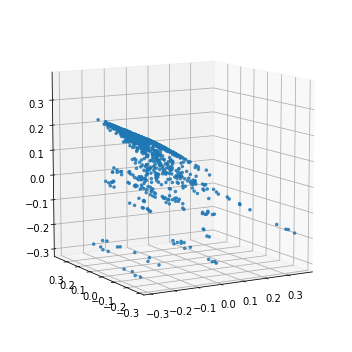

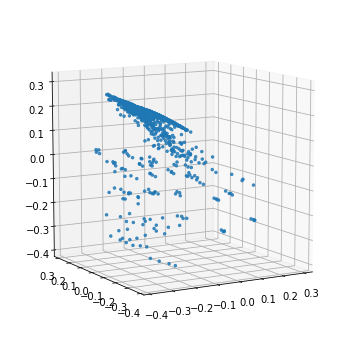

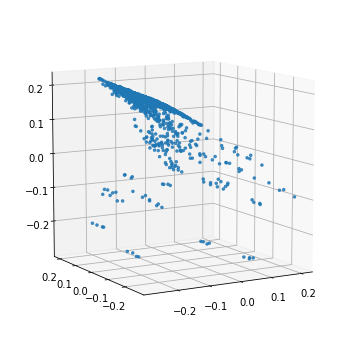

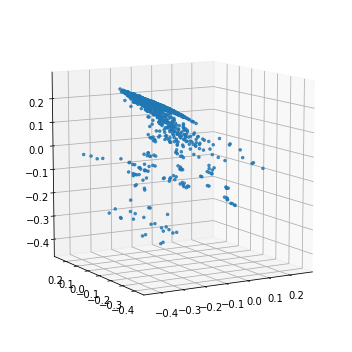

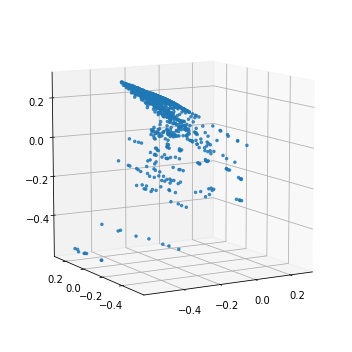

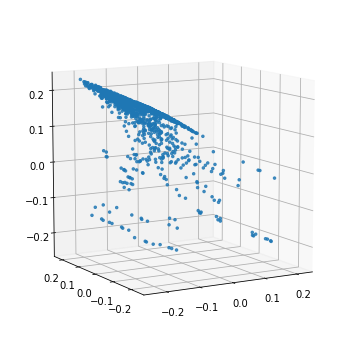

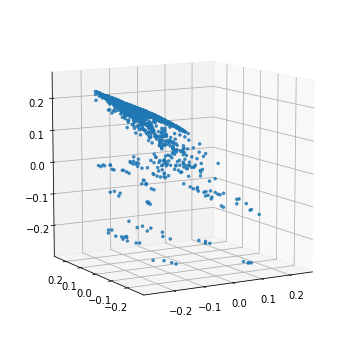

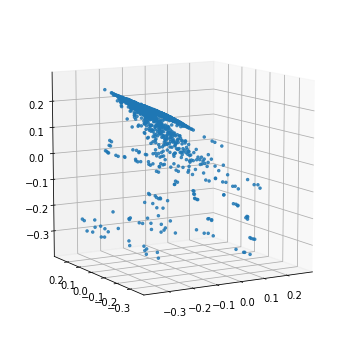

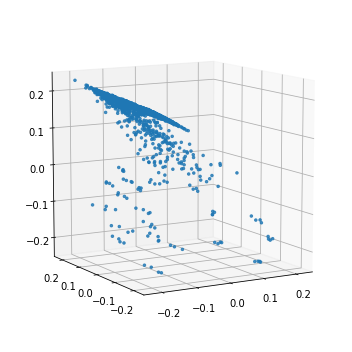

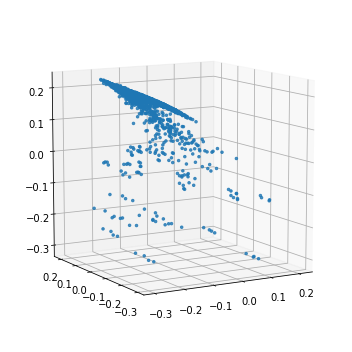

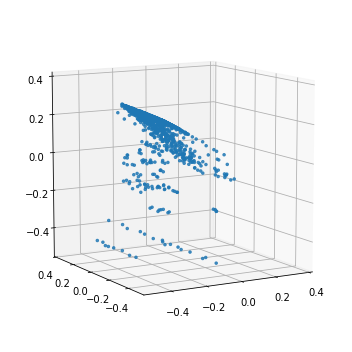

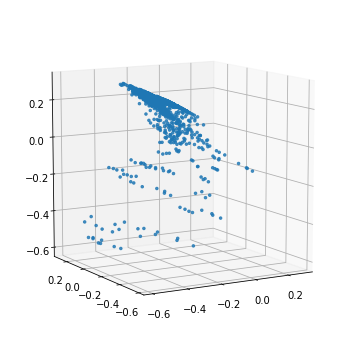

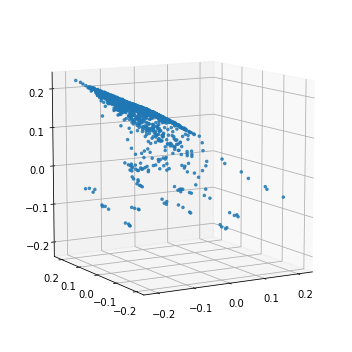

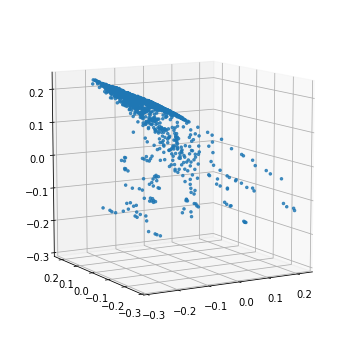

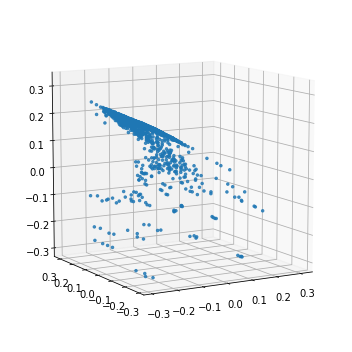

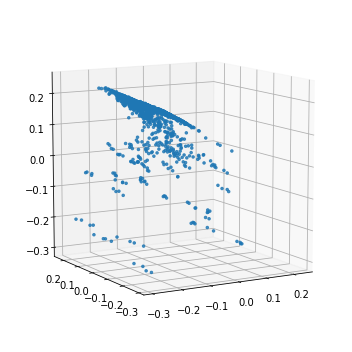

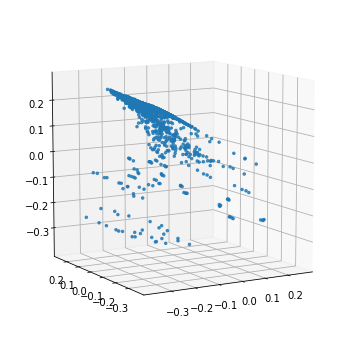

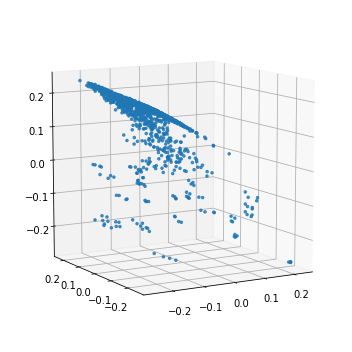

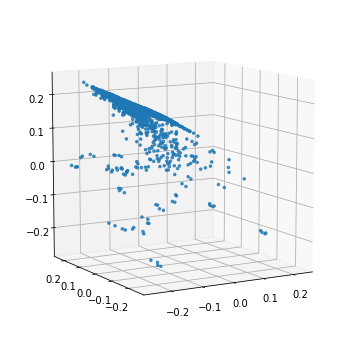

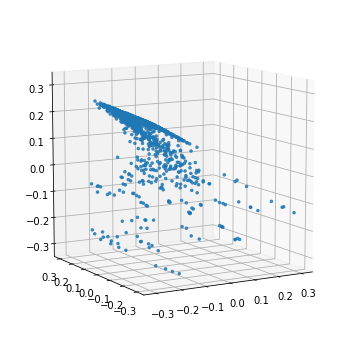

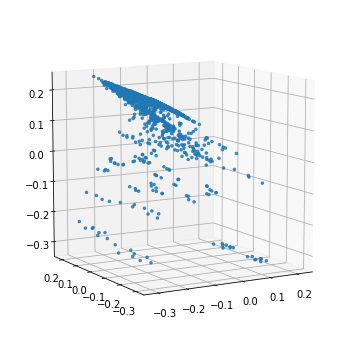

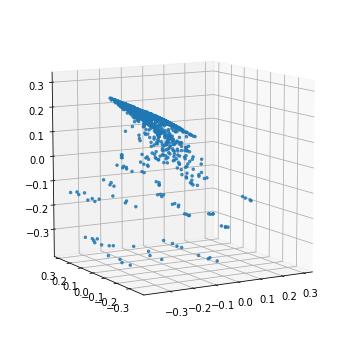

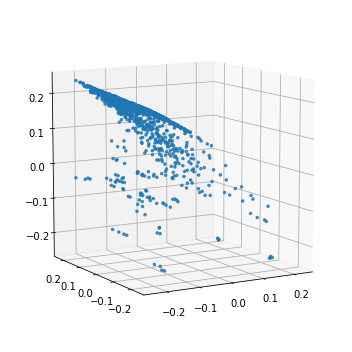

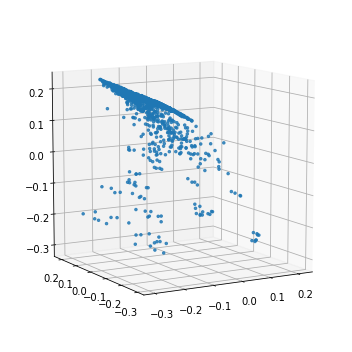

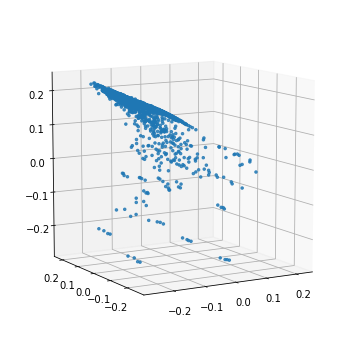

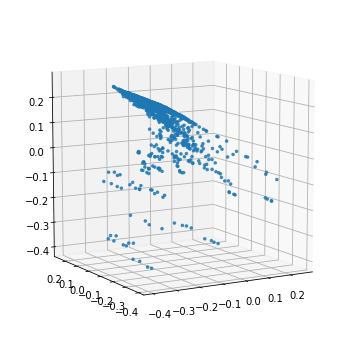

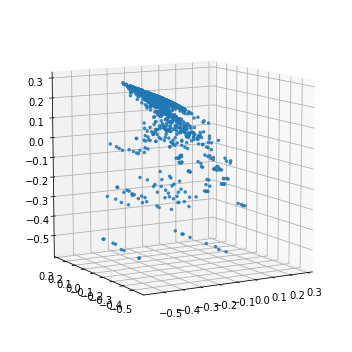

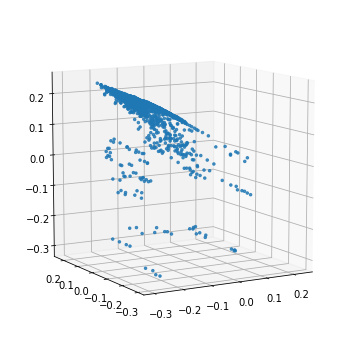

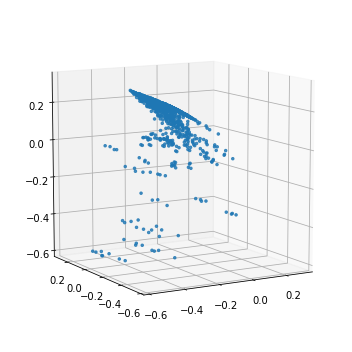

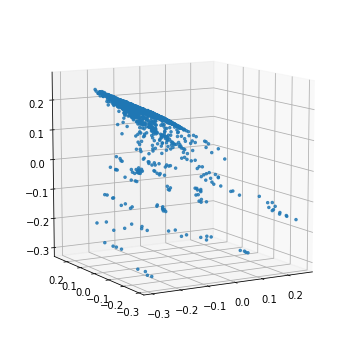

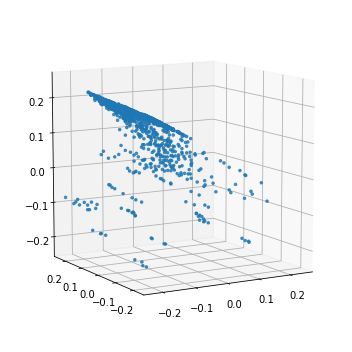

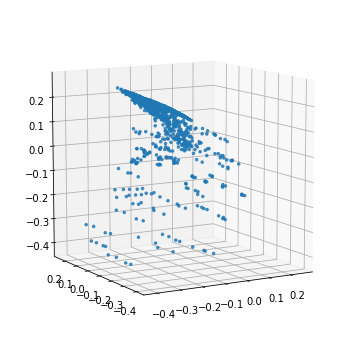

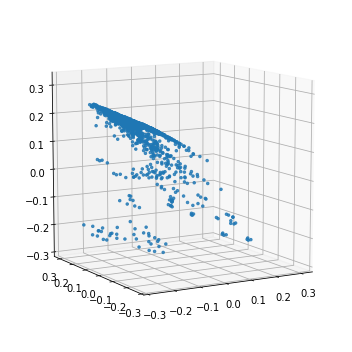

In [19]:
n = pc_gen.shape[0]
for i in range(n):
    plot_3d_point_cloud(pc_gen[i][:, 0], pc_gen[i][:, 1], pc_gen[i][:, 2], s = 25, in_u_sphere=False)

In [ ]:
# # testing
# for test_no in range(config.N_test):

#     noise = np.random.normal(size=[config.batch_size, config.z_size], scale=0.2)
#     img = model.generate(noise)

#     try:
#     if not os.path.exists(config.render_dir):
#         os.makedirs(config.render_dir)
#     except OSError:\
#         print('Error: Creating directory. ' + config.render_dir)